## Analysing csv data 
### Step 1: Import Spark and initialising spark

In [1]:
import os
os.environ['PYSPARK_SUBMIT_ARGS'] = '--packages org.mongodb.spark:mongo-spark-connector_2.11:2.4.0 pyspark-shell'
# create entry points to spark
from pyspark import SparkContext, SparkConf # Spark
from pyspark.sql import SparkSession,SQLContext # Spark SQL

# Create Spark Conf
sc_conf = SparkConf().setMaster("local[*]").setAppName('my spark app')
# Create Spark Context
sc = SparkContext(conf=sc_conf)
spark = SparkSession(sparkContext=sc)\
    .builder \
    .config("spark.jars.packages", "org.mongodb.spark:mongo-spark-connector_2.11:2.4.0")\
    .config("spark.mongodb.input.uri", "mongodb://127.0.0.1/demo_db.ass1") \
    .config("spark.mongodb.output.uri", "mongodb://127.0.0.1/demo_db.ass1") \
    .getOrCreate()


### Step 2: Create Dataframe

In [2]:
import csv
from io import StringIO

# define function for reading in csv
def load_records(fileNameContents):
    input = StringIO(fileNameContents[1])
    reader = csv.DictReader(input)
    return reader

# create data frame from csv file
dt_file0 = spark.read.csv("Crime_Statistics_SA_2010_present.csv", header = True, inferSchema = True)
dt_file = dt_file0.na.drop(how='all')

# print out the number of records in the data frame
print("The number of records in the file is " + str(dt_file.count()) + ".")

The number of records in the file is 727407.


### Step 3:  Write to Database

In [3]:
# write to mongodb
dt_frame = dt_file.write.format("com.mongodb.spark.sql.DefaultSource").mode("overwrite").save()


### Step 4: Read from Database

In [4]:
# Read data from mongodb
df = spark.read.format("com.mongodb.spark.sql.DefaultSource").load()
df.printSchema()

root
 |-- Offence Count: integer (nullable = true)
 |-- Offence Level 1 Description: string (nullable = true)
 |-- Offence Level 2 Description: string (nullable = true)
 |-- Offence Level 3 Description: string (nullable = true)
 |-- Postcode - Incident: string (nullable = true)
 |-- Reported Date: string (nullable = true)
 |-- Suburb - Incident: string (nullable = true)
 |-- _id: struct (nullable = true)
 |    |-- oid: string (nullable = true)



### Step 5 Calculate the statistics of numeric and string columns

In [5]:
df.describe("Offence Count","Reported Date").show()

+-------+------------------+-------------+
|summary|     Offence Count|Reported Date|
+-------+------------------+-------------+
|  count|            727407|       727407|
|   mean|1.1715174585892079|         null|
| stddev|0.5787050930378089|         null|
|    min|                 1|    1/01/2011|
|    max|                28|    9/12/2018|
+-------+------------------+-------------+



The following data can be read from the result above.
The "Offence Count" column has total count of 727407, with mean of 1.1715, standard deviation of 0.5787, minimum of 1 and maximum of 28.

The "Reported Date" column also has total count of 727407. However, the given dates are in string type, therefore it is not possible to calculate mean of stddev of the string date. Similarly, the minimum and maximum of the dates are incorrect as well. In the original data, the record starts at 1/07/2010 instead of 1/01/2011. Meanwhile, the last record date should be 31/03/2019 instead of 9/12/2018. The dates are compared with the order of string, but the correct minimum and maximum should be converted under date format.  

### Step 6: Change the data type of a column

In [6]:
# import functions for following parts
from datetime import datetime
from pyspark.sql.functions import col,udf
from pyspark.sql.types import DateType
from pyspark.sql import functions as F


In [7]:
# define a function that return string time 
fun_day = udf(lambda x: datetime.strptime(x, '%d/%m/%Y'), DateType())

# use udf to convert selected column
df2 = df.withColumn('Reported_date', fun_day(df["Reported Date"]))

df2.printSchema()


root
 |-- Offence Count: integer (nullable = true)
 |-- Offence Level 1 Description: string (nullable = true)
 |-- Offence Level 2 Description: string (nullable = true)
 |-- Offence Level 3 Description: string (nullable = true)
 |-- Postcode - Incident: string (nullable = true)
 |-- Reported Date: string (nullable = true)
 |-- Suburb - Incident: string (nullable = true)
 |-- _id: struct (nullable = true)
 |    |-- oid: string (nullable = true)
 |-- Reported_date: date (nullable = true)



### Step 7: Preliminary data analysis

In [8]:
# find level 2 offences
level2_no = df2.select(df["Offence Level 2 Description"]).distinct().count() 
level2_list = df2.select(df["Offence Level 2 Description"]).distinct().show(truncate=False)

print("There are " + str(level2_no) + " level 2 offences.")

+------------------------------------+
|Offence Level 2 Description         |
+------------------------------------+
|ROBBERY AND RELATED OFFENCES        |
|PROPERTY DAMAGE AND ENVIRONMENTAL   |
|SEXUAL ASSAULT AND RELATED OFFENCES |
|HOMICIDE AND RELATED OFFENCES       |
|ACTS INTENDED TO CAUSE INJURY       |
|SERIOUS CRIMINAL TRESPASS           |
|OTHER OFFENCES AGAINST THE PERSON   |
|FRAUD DECEPTION AND RELATED OFFENCES|
|THEFT AND RELATED OFFENCES          |
+------------------------------------+

There are 9 level 2 offences.


In [9]:
# find number of offence against the person
off_person = df2.filter(df["Offence Level 1 Description"]=="OFFENCES AGAINST THE PERSON").select(F.sum("Offence Count"))
the_off_person = off_person.collect()[0][0]
print("The number of offences against person is " + str(the_off_person))

The number of offences against person is 175644


In [10]:
# serious criminal trespasses with more than 1 offence count
cr_bigOff = df2.filter((df["Offence Level 2 Description"]=="SERIOUS CRIMINAL TRESPASS") \
                      & (df["Offence Count"]>1)).select(F.count("Offence Count"))
the_cr_bigOff = cr_bigOff.collect()[0][0]

print("There are " + str(the_cr_bigOff) + " serious criminal tresspasses with more than 1 offence count.")

There are 8579 serious criminal tresspasses with more than 1 offence count.


In [11]:
# the number of offences against the property
total_crime = df2.na.drop().select(F.sum("Offence Count"))
the_total_crime = total_crime.collect()[0][0]

# the number of total offences
off_prp = df.filter(df2["Offence Level 1 Description"] == "OFFENCES AGAINST PROPERTY").na.drop().select(F.sum("Offence Count"))
offence_prp = off_prp.collect()[0][0]

# the percentage of offences against the property
percent_prp = (offence_prp/the_total_crime)*100

print("The rate of offences against the property is " + str(round(percent_prp,2))+ str("%") + ".")

The rate of offences against the property is 79.4%.


### Step 8: Exploratory data analysis

In [12]:
# import libraries
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
from pyspark.sql.functions import unix_timestamp, dayofmonth, month, year, date_format, concat_ws

In [13]:
 # Add month and year columns to dataframe 
df2= df2.withColumn("Day", dayofmonth(df2["Reported_Date"]).cast("int"))\
    .withColumn("Month", month(df2["Reported_Date"]).cast("int"))\
    .withColumn("Year", year(df2["Reported_Date"]).cast("int"))
df2.printSchema()
                

root
 |-- Offence Count: integer (nullable = true)
 |-- Offence Level 1 Description: string (nullable = true)
 |-- Offence Level 2 Description: string (nullable = true)
 |-- Offence Level 3 Description: string (nullable = true)
 |-- Postcode - Incident: string (nullable = true)
 |-- Reported Date: string (nullable = true)
 |-- Suburb - Incident: string (nullable = true)
 |-- _id: struct (nullable = true)
 |    |-- oid: string (nullable = true)
 |-- Reported_date: date (nullable = true)
 |-- Day: integer (nullable = true)
 |-- Month: integer (nullable = true)
 |-- Year: integer (nullable = true)



In [14]:
# reorder number of crimes per year
crm_year = df2.na.drop().groupBy(df2["Year"]).count().orderBy('Year')
crm_year2 = crm_year.withColumnRenamed('count', 'CrimeCount')


In [15]:
# prepare data for plotting
crime_year = crm_year2.rdd.map(lambda x: x.Year).collect()
year_count = crm_year2.rdd.map(lambda x: x.CrimeCount).collect()


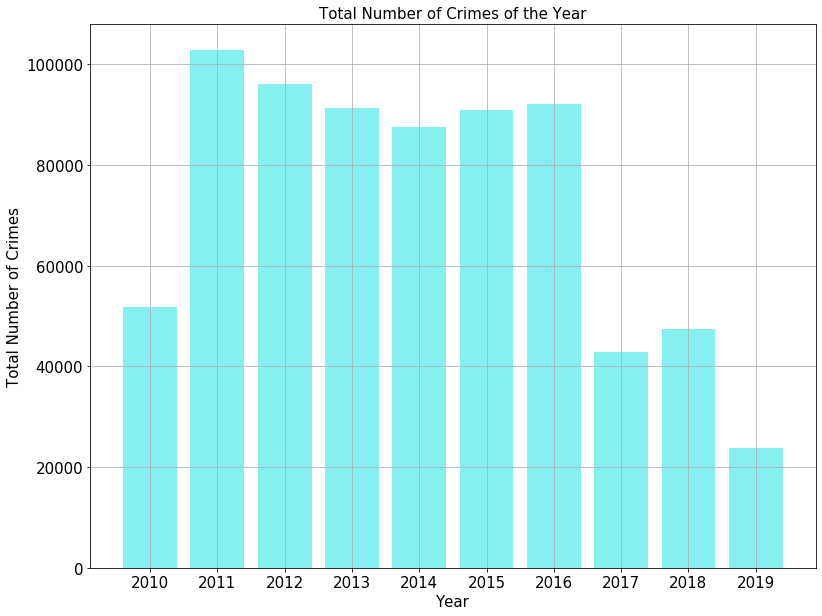

In [16]:
# yearly crime plot
fig = plt.gcf()
fig.set_size_inches(13,10)
plt.bar(crime_year, year_count, color='#86F0F0')
plt.xticks(crime_year)
plt.xlabel('Year',fontsize=15)
plt.ylabel('Total Number of Crimes',fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.title('Total Number of Crimes of the Year',fontsize=15)
plt.grid()
plt.show()


The graph shows relatively high numbers of crime close to 100,000 per year between 2011 and 2016, whereas the numbers of crime in the rest time are almost half of the former. 

Considering na.drop are used for grouping data, this condition may resulted from invalid record, but not necessarily mean the total crime rate during the period is low. 

In [17]:
# reorder number of crimes per month
crm_month = df2.groupBy(df2["Month"]).count().orderBy('Month')
crm_month2 = crm_month.withColumnRenamed('count', 'CrimeCount')

crime_month = crm_month2.rdd.map(lambda x: x.Month).collect()
month_count = crm_month2.rdd.map(lambda x: x.CrimeCount).collect()

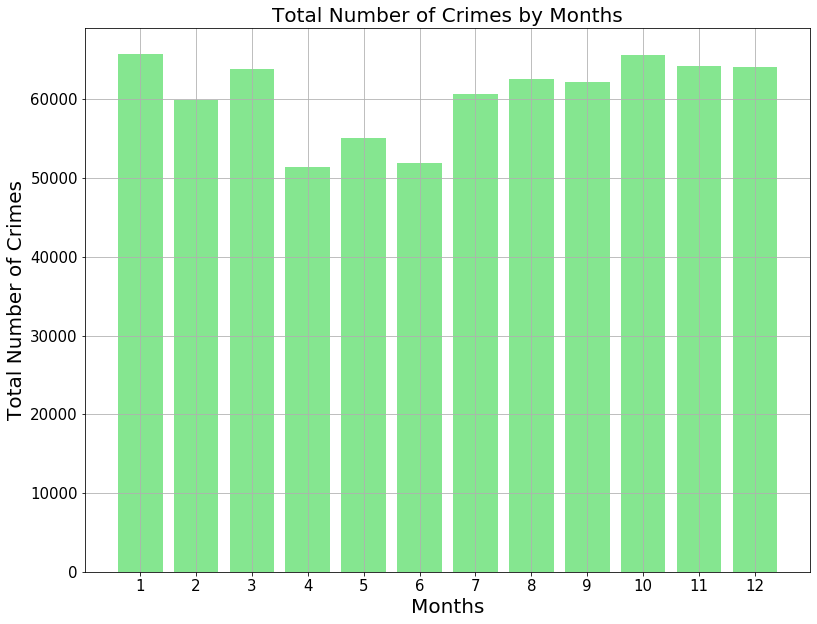

In [18]:
# monthly crime plot
fig = plt.gcf()
fig.set_size_inches(13,10)
plt.bar(crime_month, month_count,color='#85E690')
plt.xticks(crime_month)
plt.xlabel('Months', fontsize=20)
plt.ylabel('Total Number of Crimes', fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.title('Total Number of Crimes by Months', fontsize=20)
plt.grid()
plt.show()

The accumulated number of crimes per month show that most of the months have crime occurence of over 60,000 per month. However, the crime count from April to Jun are relatively low, it is likely that the crime rate is related to season. Less crimes take place in winter.   

In [19]:
# top 20 crime areas sort by post code

# prepare dataframe
df3 = df2.withColumnRenamed('Postcode - Incident', 'Postcode')\
    .withColumnRenamed('Suburb - Incident', 'Suburb')
df4 = df3.withColumn('SubPost',concat_ws('-',df3["Suburb"],df3["Postcode"]))
df4.printSchema()


root
 |-- Offence Count: integer (nullable = true)
 |-- Offence Level 1 Description: string (nullable = true)
 |-- Offence Level 2 Description: string (nullable = true)
 |-- Offence Level 3 Description: string (nullable = true)
 |-- Postcode: string (nullable = true)
 |-- Reported Date: string (nullable = true)
 |-- Suburb: string (nullable = true)
 |-- _id: struct (nullable = true)
 |    |-- oid: string (nullable = true)
 |-- Reported_date: date (nullable = true)
 |-- Day: integer (nullable = true)
 |-- Month: integer (nullable = true)
 |-- Year: integer (nullable = true)
 |-- SubPost: string (nullable = false)



In [20]:
# group data by suburbs
subPos = df4.filter(df4['Postcode'] != "NOT DISCLOSED").groupBy(df4["SubPost"]).agg({'Offence Count': 'sum'})\
    .withColumnRenamed('sum(Offence Count)', 'sumOffence')\
    .orderBy("sumOffence", ascending = False)


In [21]:
# extract list for plot variables 
theLocation = subPos.rdd.map(lambda x: x.SubPost).collect()[0:19]
locCrime = subPos.rdd.map(lambda x: x.sumOffence).collect()[0:19]


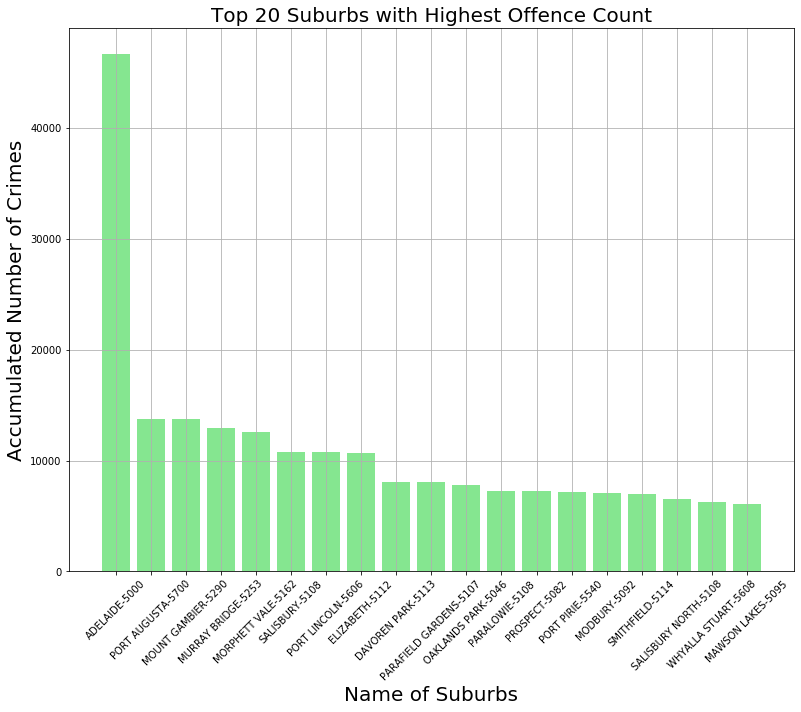

In [22]:
# plot for top 20 high crime rate suburbs
fig = plt.gcf()
fig.set_size_inches(13,10)
plt.bar(theLocation, locCrime, color='#85E690')
plt.xticks(rotation=45)
plt.xlabel('Name of Suburbs', fontsize=20)
plt.ylabel('Accumulated Number of Crimes', fontsize=20)
plt.title('Top 20 Suburbs with Highest Offence Count', fontsize=20)
plt.grid()
plt.show()

It can be seen from the above figure that "Adelaide - 5000" has an outstandingly high amount of all times. It can be an outlier for the rest of data when making contrast. 

In [23]:
# find # of serious criminal trespasses by day and month
# convert time data to day of week
df5 = df4.na.drop().withColumn('DayofWeek', date_format('Reported_date', 'E').alias('dayOfWk'))


In [24]:
# sort out data by offence description and day of week
#group data by month first
month_tres = df5.filter(df5["Offence Level 2 Description"]=="SERIOUS CRIMINAL TRESPASS")\
    .groupBy(df5["Month"],df5["DayofWeek"])\
    .agg({'Offence Count': 'sum'})\
    .withColumnRenamed('sum(Offence Count)', 'sumOffence')\
    .orderBy(df5["Month"])

# month_tres.show()

# filter data for Monday 
day_tres1 = month_tres.filter(month_tres["DayofWeek"]=="Mon")

day_tres2 = month_tres.filter(month_tres["DayofWeek"]=="Tue")

day_tres3 = month_tres.filter(month_tres["DayofWeek"]=="Wed")

day_tres4 = month_tres.filter(month_tres["DayofWeek"]=="Thu")

day_tres5 = month_tres.filter(month_tres["DayofWeek"]=="Fri")

day_tres6 = month_tres.filter(month_tres["DayofWeek"]=="Sat")

day_tres7 = month_tres.filter(month_tres["DayofWeek"]=="Sun")

# list for label tick
mon_list = month_tres.groupBy(month_tres["Month"]).count().orderBy("Month")

mon_list1 = mon_list.rdd.map(lambda x: x.Month).collect()

print(mon_list1)

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]


In [25]:
# x and y for Monday
tres_month1 = day_tres1.rdd.map(lambda x: x.Month).collect()
tres_count1 = day_tres1.rdd.map(lambda x: x.sumOffence).collect()

# x and y for Tue
tres_month2 = day_tres2.rdd.map(lambda x: x.Month).collect()
tres_count2 = day_tres2.rdd.map(lambda x: x.sumOffence).collect()

# x and y for Tue
tres_month3 = day_tres3.rdd.map(lambda x: x.Month).collect()
tres_count3 = day_tres3.rdd.map(lambda x: x.sumOffence).collect()

# x and y for Tue
tres_month4 = day_tres4.rdd.map(lambda x: x.Month).collect()
tres_count4 = day_tres4.rdd.map(lambda x: x.sumOffence).collect()

# x and y for Tue
tres_month5 = day_tres5.rdd.map(lambda x: x.Month).collect()
tres_count5 = day_tres5.rdd.map(lambda x: x.sumOffence).collect()

# x and y for Tue
tres_month6 = day_tres6.rdd.map(lambda x: x.Month).collect()
tres_count6 = day_tres6.rdd.map(lambda x: x.sumOffence).collect()

# x and y for Tue
tres_month7 = day_tres7.rdd.map(lambda x: x.Month).collect()
tres_count7 = day_tres7.rdd.map(lambda x: x.sumOffence).collect()


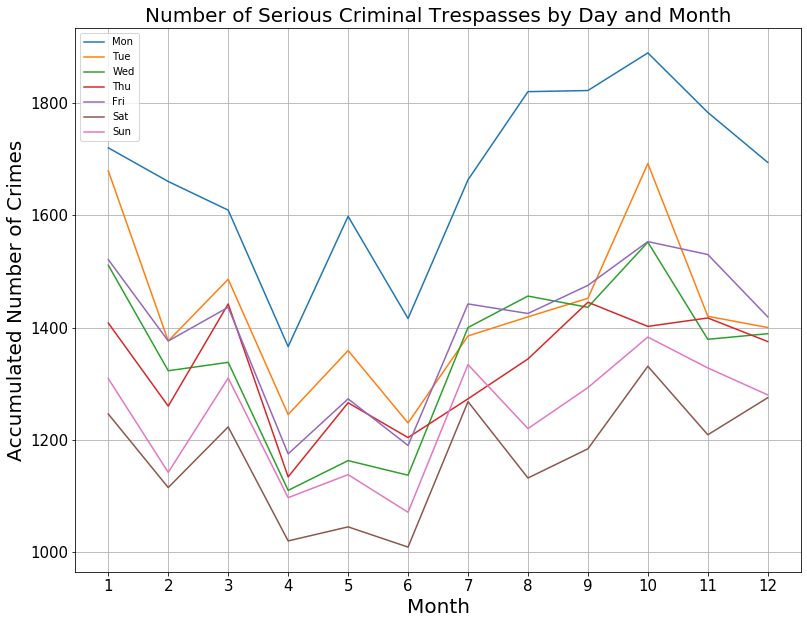

----------------------------------------
Exception happened during processing of request from ('127.0.0.1', 49834)
Traceback (most recent call last):
  File "/usr/lib/python3.6/socketserver.py", line 320, in _handle_request_noblock
    self.process_request(request, client_address)
  File "/usr/lib/python3.6/socketserver.py", line 351, in process_request
    self.finish_request(request, client_address)
  File "/usr/lib/python3.6/socketserver.py", line 364, in finish_request
    self.RequestHandlerClass(request, client_address, self)
  File "/usr/lib/python3.6/socketserver.py", line 724, in __init__
    self.handle()
  File "/home/anni/jupyter/lib/python3.6/site-packages/pyspark/accumulators.py", line 269, in handle
    poll(accum_updates)
  File "/home/anni/jupyter/lib/python3.6/site-packages/pyspark/accumulators.py", line 241, in poll
    if func():
  File "/home/anni/jupyter/lib/python3.6/site-packages/pyspark/accumulators.py", line 245, in accum_updates
    num_updates = read_int(sel

In [26]:
# Plot

fig = plt.gcf()
fig.set_size_inches(13,10)
plt.plot(tres_month1, tres_count1, label = "Mon")
plt.plot(tres_month2, tres_count2, label = "Tue")
plt.plot(tres_month3, tres_count3, label = "Wed")
plt.plot(tres_month4, tres_count4, label = "Thu")
plt.plot(tres_month5, tres_count5, label = "Fri")
plt.plot(tres_month6, tres_count6, label = "Sat")
plt.plot(tres_month7, tres_count7, label = "Sun")
plt.xticks(mon_list1, fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel('Month', fontsize=20)
plt.ylabel('Accumulated Number of Crimes', fontsize=20)
plt.title('Number of Serious Criminal Trespasses by Day and Month', fontsize=20)
plt.legend()
plt.grid()
plt.show()

From the figure above, it can be seen that crime occurence on Monday has remarkbaly high number other than other days. The crime counts between Tuesday and Fridays are close to each other. Weekends have the lowest counts of crimes. 

A possible reason is that more people are at home on weekend than weekdays, so the criminals are less likely to conduct house breaking. However, they are more likely to commit crimes on Monday for financial reasons. 

Also, people who have jobs may feel harder to control bad mood when going back to work on Monday, which may result in higher rate of violence cases on that day. 

The above figure also show decrease of crime count between April and June (the winter months) and decrease of crime count between October and December (the summer months). 

The plot also show rising trend of crime count between Jun and October. The trend are consistent with the analysis of accumulated crime count per months, parallel to the change of season. Crimes are likely to take place on spring, but less likely in winter and mid summer, when the weather is extreme. 